## Our task here is to restore images after convolution with some filter. 

The optimization problem is the following:
$$y = argmin \left(\frac{1}{2 \sigma}(||z - Ay ||_2^2) + \tau p(y)\right), $$
where $$z = Ay + \sigma \varepsilon, $$ 

$z \in \mathbb{R}^M$ - observed image,

$y \in \mathbb{R}^N$ - true image we are trying to find, 

$A$ - $M \times N$ blur matrix, 

$\varepsilon \sim N(0, I)$, 

$\sigma$ - standard deviation of noise, 

$\tau > 0$ - regalarization parameter, 

$p(y)$ - penalty. 

This functional is convex 

We will consider the following penalty functions: 
- $p(y) = || y ||_1$
- $p(y) = || y ||_2$

In [79]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
np.random.seed(666)
import sklearn
from sklearn import metrics
import pandas as pd
% matplotlib inline

**Firstly we will consider the convolution kernel, that produces "weak" blur**

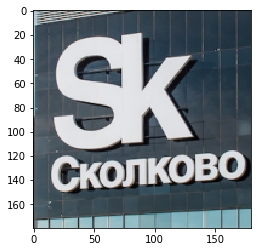

In [6]:
def create_gaussian_kernel(bound, size):
    t = np.linspace(-bound, bound, size)
    bump = np.exp(-0.1*t**2)
    kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
    kernel = kernel/kernel.sum()
    return kernel


kernel = create_gaussian_kernel(4, 4)

k = kernel.shape[0]


def padwithtens(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector

def resize_img(img, pad_size):
    y = np.zeros((img.shape[0]+pad_size[0]+pad_size[1], img.shape[1]+pad_size[0]+pad_size[1], img.shape[2]-1))
    for i in range(img.shape[2]-1):
        y[:,:,i] = np.lib.pad(img[:,:,i], pad_size, padwithtens)
    return y.reshape(y.shape[0]**2, y.shape[2])

pad = (k//2,k//2)

img = plt.imread('SkTpSq.png')
plt.figure()
plt.imshow(img)

pad_img = resize_img(img, pad)

**Now we want to reduce the convolution to multiplication by matrix. **

In [7]:
def create_matrix(kernel, image_size): # creates
    k = kernel.shape[0]
    tmp = np.zeros(((image_size+k)**2, image_size))
    tmp1 = np.zeros(((image_size+k)**2))
    for i in range(k):
        tmp1[i*(image_size+k):i*(image_size+k) + k] += kernel[i]
    tmp[:,0] += tmp1
    for i in range(1, image_size):
        tmp[i:,i] += tmp1[:-i]
    #print(tmp.shape)
    tmp = tmp.T
    k = kernel.shape[0]
    final = sparse.csr_matrix(tmp)
    tmp = sparse.csr_matrix(tmp)
    for i in range(1, image_size):
        sparse_zeros = sparse.csr_matrix(np.zeros((image_size, (image_size+k)*i)))
        sparse_tmp = sparse.csr_matrix(sparse.hstack((sparse_zeros, tmp[:,:-(image_size+k)*i])))
        final = sparse.vstack((final, sparse_tmp))
    return final

A = create_matrix(kernel, img.shape[0])

In [4]:
new_img = A@pad_img
new_size = int(np.sqrt(new_img.shape[0]))
blurred_img = new_img.reshape((new_size,new_size, img.shape[2]-1))

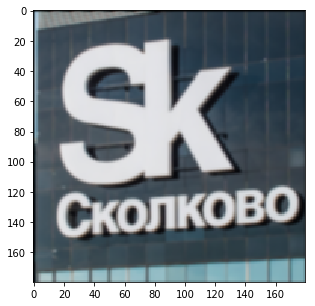

In [5]:
plt.figure(figsize = (5, 5))
plt.imshow(blurred_img)

In [6]:
sigma= 1e-3
blurred_with_noise = blurred_img + sigma*np.random.randn(blurred_img.shape[0],blurred_img.shape[1], 3)

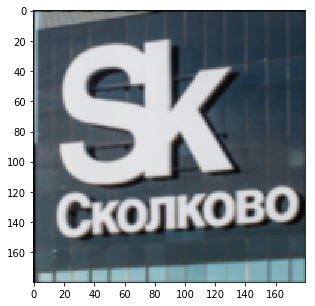

In [7]:
plt.figure(figsize = (5, 5))
plt.imshow(blurred_with_noise)

In [8]:
blurred_with_noise = blurred_img + sigma*np.random.randn(blurred_img.shape[0],blurred_img.shape[1], 3)

In [8]:
import scipy
import scipy.optimize

In [69]:
# loss function
def loss(A, y, z, tau, norm):
    
    if norm == 'l1':
        return 1. / (2 * sigma) * (np.linalg.norm(z - A @ y)) ** 2 + tau * np.linalg.norm(y, ord=1)
    if norm == 'l2':
        return 1. / (2 * sigma) * (np.linalg.norm(z - A @ y)) ** 2 + tau * np.linalg.norm(y)

# full loss for all color channels of the image
def full_loss(A, y, z, tau, norm):
    
    return loss(A, y[:, 0], z[:, 0], tau, norm) + loss(A, y[:, 1], z[:, 1], tau, norm) + loss(A, y[:, 2], z[:, 2], tau, norm)

# gradient function
def gradient(A, y, z, tau, norm):
    
    I = np.ones(len(y))
    if norm == 'l1':
        return 1. / sigma * A.T @ (A @ y - z) + tau * I
    if norm == 'l2':
        return 1. / sigma * A.T @ (A @ y - z) + 2 * tau * y

# full gradient for color channels of the image
def full_gradient(A, y, z, tau, norm):
    
    grad = np.zeros(y.shape)
    grad[:, 0] = gradient(A, y[:, 0], z[:, 0], tau, norm)
    grad[:, 1] = gradient(A, y[:, 1], z[:, 1], tau, norm)
    grad[:, 2] = gradient(A, y[:, 2], z[:, 2], tau, norm)
    return grad

In [70]:
# hessian of loss function
def hessian(A, tau, norm):
    
    I = scipy.sparse.eye((A.T @ A).shape[0])
    if norm == 'l1':
        return 1./sigma * A.T @ A
    if norm == 'l2':
        return 1./sigma * A.T @ A + 2 * tau * I

In [12]:
tau = 1e-3
tol = 100

In [13]:
H_l1 = hessian(A, tau, norm = 'l1')
H_l2 = hessian(A, tau, norm = 'l2')

In [14]:
global H_l1, H_l2, pad_img

Newton algorithm: $$x_{n+1}=x_n - \gamma [Hf(x_n)]^{-1}\nabla f(x_n),$$

where $\gamma$ - small step size $\in (0, 1)$, $H$ - hessian

As it's really expensive to compute inverse of the hessian(the core dumps even for images 50x50), we can calculate $\Delta x_n=x_{n+1}-x_n$ as the solution of linear system $$[Hf(x_n)]\Delta x=-\Delta f(x_n)$$
via iterative methods. For example, with $gmres$.

In [71]:
# newton method    
def newton(A, y, z, tau, tol, H, original, norm='l2', gamma = 0.05, maxiter = 500):
    
    loss = []
    RMSE = []
    cur_iter = 0
    dy = np.zeros(y.shape)
    while (full_loss(A, y, z, tau, norm) > tol and cur_iter < maxiter):
        
        tot_gr = full_gradient(A, y, z, tau, norm)
        ob1 = scipy.sparse.linalg.gmres(H, (-gamma) * full_gradient(A, y, z, tau, norm)[:, 0], tol=1e-1)[0]
        ob1 = ob1[:, np.newaxis]
        ob2 = scipy.sparse.linalg.gmres(H, (-gamma) * full_gradient(A, y, z, tau, norm)[:, 1], tol=1e-1)[0]
        ob2 = ob2[:, np.newaxis]
        ob3 = scipy.sparse.linalg.gmres(H, (-gamma) * full_gradient(A, y, z, tau, norm)[:, 2], tol=1e-1)[0]
        ob3 = ob3[:, np.newaxis]
        
        dy = np.hstack([ob1, ob2, ob3])
        y += dy
        y[y < 0] = 0
        y[y > 1] = 1
        cur_iter = cur_iter + 1
        
        # at every step we compute function of full loss and RMSE(mean squared error - "distance" to the original image)
        loss.append(full_loss(A, y, z, tau, norm))
        RMSE.append(sklearn.metrics.mean_squared_error(y, original))
        
    return y, loss, RMSE   

**Let's try to recover the image via newton method with l1 penalty function. We'll consider here different different initializations for newton method: blurred image, zeros, ones and random.**

In [66]:
import time
from time import time

In [65]:
def resize_y(img, pad_size): 
    y = np.zeros((img.shape[0] + pad_size[0] + pad_size[1], img.shape[1] + pad_size[0] + pad_size[1], img.shape[2])) 
    for i in range(img.shape[2]): 
        y[:,:,i] = np.lib.pad(img[:,:,i], pad_size, padwithtens) 
    return y.reshape(y.shape[0]**2, y.shape[2])

In [18]:
y = resize_y(blurred_with_noise, pad)
z = blurred_with_noise.reshape((blurred_with_noise.shape[0] ** 2, 3))

In [19]:
start = time()
y_final_l1_blur, loss_l1_blur, RMSE_l1_blur = newton(A, y, z, tau, tol, H_l1, pad_img, norm='l1')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 19.49 sec


In [20]:
np.savetxt("loss1_l1.csv", loss_l1_blur, delimiter=",")
np.savetxt("RMSE1_l1.csv", RMSE_l1_blur, delimiter=",")

In [21]:
y = np.zeros((A.shape[1], 3))
z = blurred_with_noise.reshape((blurred_with_noise.shape[0] ** 2, 3))

In [22]:
start = time()
y_final_l1_zeros, loss_l1_zeros, RMSE_l1_zeros = newton(A, y, z, tau, tol, H_l1, pad_img, norm='l1')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 25.46 sec


In [23]:
y = np.ones((A.shape[1], 3))
z = blurred_with_noise.reshape((blurred_with_noise.shape[0] ** 2, 3))

In [24]:
start = time()
y_final_l1_ones, loss_l1_ones, RMSE_l1_ones = newton(A, y, z, tau, tol, H_l1, pad_img, norm='l1')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 80.95 sec


In [25]:
y = np.random.rand(A.shape[1], 3)
z = blurred_with_noise.reshape((blurred_with_noise.shape[0] ** 2, 3))

In [26]:
start = time()
y_final_l1_rand, loss_l1_rand, RMSE_l1_rand = newton(A, y, z, tau, tol, H_l1, pad_img, norm='l1')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 96.45 sec


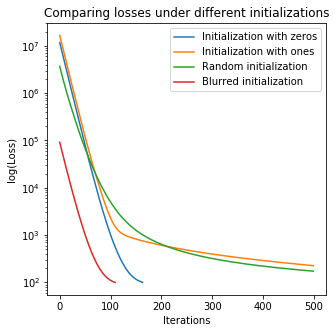

In [27]:
plt.figure(figsize=(5, 5))
plt.semilogy(loss_l1_zeros)
plt.semilogy(loss_l1_ones)
plt.semilogy(loss_l1_rand)
plt.semilogy(loss_l1_blur)
plt.title('Comparing losses under different initializations')
plt.xlabel('Iterations')
plt.ylabel('log(Loss)')
plt.legend(['Initialization with zeros', 'Initialization with ones', 'Random initialization', 'Blurred initialization'])

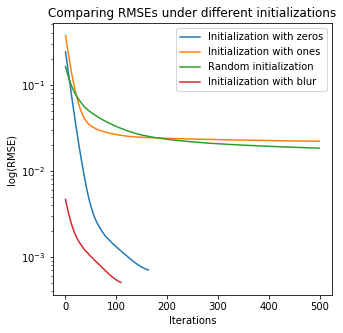

In [28]:
plt.figure(figsize=(5, 5))
plt.semilogy(RMSE_l1_zeros)
plt.semilogy(RMSE_l1_ones)
plt.semilogy(RMSE_l1_rand)
plt.semilogy(RMSE_l1_blur)
plt.title('Comparing RMSEs under different initializations')
plt.xlabel('Iterations')
plt.ylabel('log(RMSE)')
plt.legend(['Initialization with zeros', 'Initialization with ones', 'Random initialization', 'Initialization with blur'])

**As we see, the best initialization here is cropped blurred image**

In [30]:
size = int(np.sqrt(y_final_l1_blur.shape[0]))

In [31]:
img_final_l1 = y_final_l1_blur.reshape((size, size, 3))[pad[0]:-pad[1], pad[0]:-pad[1], :]

Text(0.5,1,'Restored, l1 penalty function')

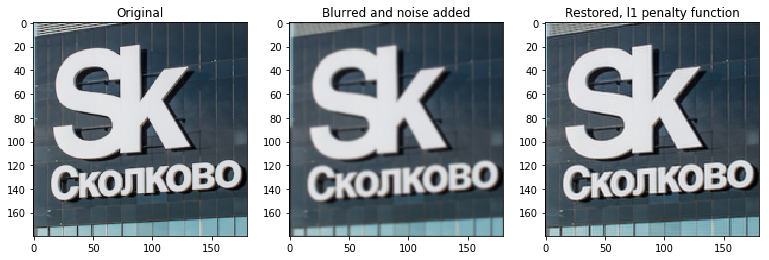

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(13, 13))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(blurred_with_noise, cmap='gray')
ax[1].set_title('Blurred and noise added')
ax[2].imshow(img_final_l1, cmap='gray')
ax[2].set_title('Restored, l1 penalty function')

**Now let's use l2 penalty function**

In [33]:
y = resize_y(blurred_with_noise, pad)
z = blurred_with_noise.reshape((blurred_with_noise.shape[0] ** 2, 3))

In [34]:
start = time()
y_final_l2_blur, loss_l2_blur, RMSE_l2_blur = newton(A, y, z, tau, tol, H_l1, pad_img, norm='l2')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 15.15 sec


In [35]:
np.savetxt("loss1_l2.csv", loss_l2_blur, delimiter=",")
np.savetxt("RMSE1_l2.csv", RMSE_l2_blur, delimiter=",")

In [36]:
y = np.zeros((A.shape[1], 3))
z = blurred_with_noise.reshape((blurred_with_noise.shape[0] ** 2, 3))

In [37]:
start = time()
y_final_l2_zeros, loss_l2_zeros, RMSE_l2_zeros = newton(A, y, z, tau, tol, H_l1, pad_img, norm='l2')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 20.28 sec


In [38]:
y = np.ones((A.shape[1], 3))
z = blurred_with_noise.reshape((blurred_with_noise.shape[0] ** 2, 3))

In [39]:
start = time()
y_final_l2_ones, loss_l2_ones, RMSE_l2_ones = newton(A, y, z, tau, tol, H_l2, pad_img, norm='l2')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 81.04 sec


In [40]:
y = np.random.rand(A.shape[1], 3)
z = blurred_with_noise.reshape((blurred_with_noise.shape[0] ** 2, 3))

In [41]:
start = time()
y_final_l2_rand, loss_l2_rand, RMSE_l2_rand = newton(A, y, z, tau, tol, H_l2, pad_img, norm='l2')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 103.17 sec


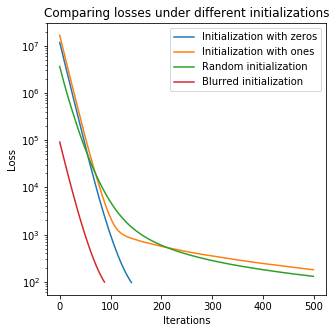

In [42]:
plt.figure(figsize=(5, 5))
plt.semilogy(loss_l2_zeros)
plt.semilogy(loss_l2_ones)
plt.semilogy(loss_l2_rand)
plt.semilogy(loss_l2_blur)
plt.title('Comparing losses under different initializations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(['Initialization with zeros', 'Initialization with ones', 'Random initialization', 'Blurred initialization'])

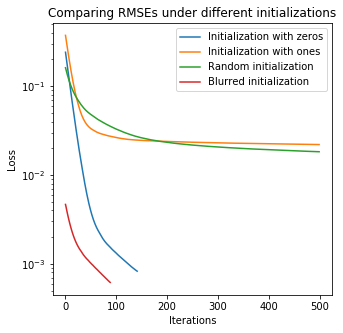

In [43]:
plt.figure(figsize=(5, 5))
plt.semilogy(RMSE_l2_zeros)
plt.semilogy(RMSE_l2_ones)
plt.semilogy(RMSE_l2_rand)
plt.semilogy(RMSE_l2_blur)
plt.title('Comparing RMSEs under different initializations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(['Initialization with zeros', 'Initialization with ones', 'Random initialization', 'Blurred initialization'])

**Here we will also use blurred image as initialization**

In [44]:
size = int(np.sqrt(y_final_l2_blur.shape[0]))

In [45]:
img_final_l2 = y_final_l2_blur.reshape((size, size, 3))[pad[0]:-pad[1], pad[0]:-pad[1], :]

Text(0.5,1,'Restored, l2 penalty function')

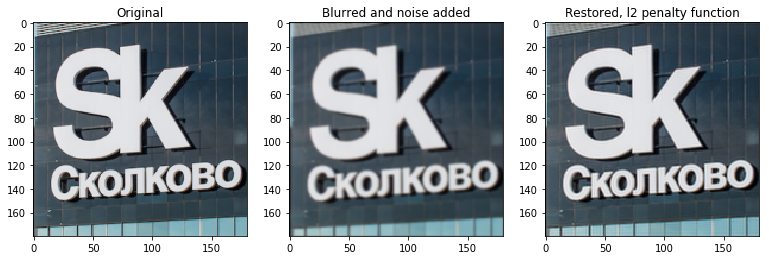

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(13, 13))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(blurred_with_noise, cmap='gray')
ax[1].set_title('Blurred and noise added')
ax[2].imshow(img_final_l2, cmap='gray')
ax[2].set_title('Restored, l2 penalty function')

### Now let's use the other kernel, that will give us more powerful blurring

In [13]:
kernel2 = create_gaussian_kernel(3, 15)
k2 = kernel2.shape[0]

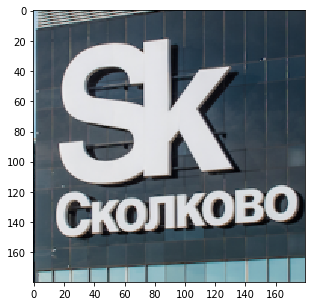

In [18]:
pad2 = (k2//2, k2//2 + 1)

img2 = plt.imread('SkTpSq.png')
plt.figure(figsize=(5, 5))
plt.imshow(img2)

pad_img2 = resize_img(img2, pad2)

In [19]:
A2 = create_matrix(kernel2, img2.shape[0])

In [20]:
new_img2 = A2 @ pad_img2
new_size2 = int(np.sqrt(new_img2.shape[0]))
blurred_img2 = new_img2.reshape((new_size2, new_size2, img2.shape[2] - 1))

In [21]:
sigma= 1e-3
blurred_with_noise2 = blurred_img2 + sigma * np.random.randn(blurred_img2.shape[0], blurred_img2.shape[1], 3)

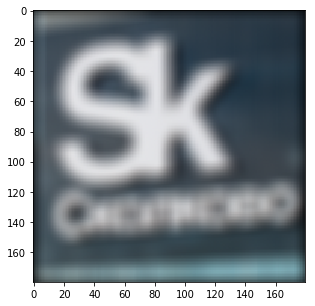

In [22]:
plt.figure(figsize = (5, 5))
plt.imshow(blurred_with_noise2)

In [25]:
H2_l1 = hessian(A2, tau, norm = 'l1')
H2_l2 = hessian(A2, tau, norm = 'l2')

In [54]:
global H2_l1, H2_l2, pad_img2

**As we found out, it's better to use blurred image as initialization**

In [55]:
y2 = resize_y(blurred_with_noise2, pad2)
z2 = blurred_with_noise2.reshape((blurred_with_noise2.shape[0] ** 2, 3))

In [56]:
start = time()
y2_final_l1_blur, loss2_l1_blur, RMSE2_l1_blur = newton(A2, y2, z2, tau, tol, H2_l1, pad_img2, norm='l1')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 1443.21 sec


In [57]:
np.savetxt("loss2_l1.csv", loss2_l1_blur, delimiter=",")
np.savetxt("RMSE2_l1.csv", RMSE2_l1_blur, delimiter=",")

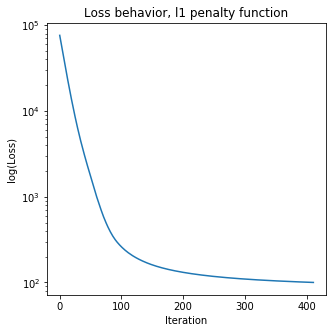

In [100]:
plt.figure(figsize=(5, 5))
plt.title('Loss behavior, l1 penalty function')
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.semilogy(loss2_l1_blur)

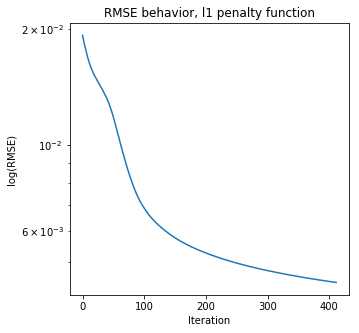

In [97]:
plt.figure(figsize=(5, 5))
plt.title('RMSE behavior, l1 penalty function')
plt.xlabel('Iteration')
plt.ylabel('log(RMSE)')
plt.semilogy(RMSE2_l1_blur)

In [60]:
size2 = int(np.sqrt(y2_final_l1_blur.shape[0]))

In [61]:
img2_final_l1 = y2_final_l1_blur.reshape((size2, size2, 3))[pad2[0]:-pad2[1], pad2[0]:-pad2[1], :]

Text(0.5,1,'Restored, l1 penalty function')

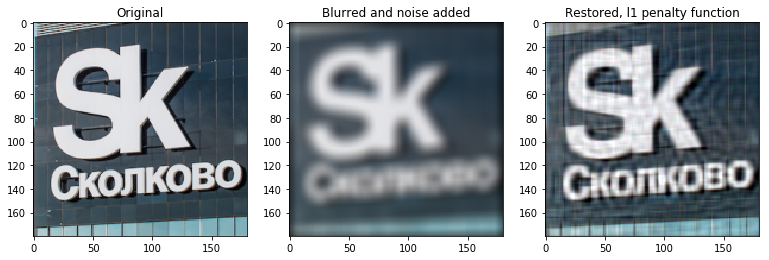

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(13, 13))

ax[0].imshow(img2, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(blurred_with_noise2, cmap='gray')
ax[1].set_title('Blurred and noise added')
ax[2].imshow(img2_final_l1, cmap='gray')
ax[2].set_title('Restored, l1 penalty function')

**Now let's do the restoration with l2 penalty function**

In [63]:
y2 = resize_y(blurred_with_noise2, pad2)
z2 = blurred_with_noise2.reshape((blurred_with_noise2.shape[0] ** 2, 3))

In [64]:
start = time()
y2_final_l2_blur, loss2_l2_blur, RMSE2_l2_blur = newton(A2, y2, z2, tau, tol, H2_l2, pad_img2, norm='l2')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 571.68 sec


In [65]:
np.savetxt("loss2_l2.csv", loss2_l2_blur, delimiter=",")
np.savetxt("RMSE2_l2.csv", RMSE2_l2_blur, delimiter=",")

In [82]:
loss2_l2_blur = pd.read_csv('loss2_l2.csv')

In [88]:
len(loss2_l2_blur)

175

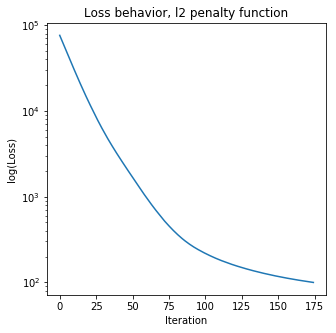

In [91]:
plt.figure(figsize=(5, 5))
plt.title('Loss behavior, l2 penalty function')
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.semilogy(loss2_l2_blur)

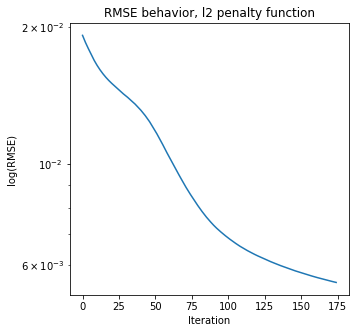

In [95]:
plt.figure(figsize=(5, 5))
plt.title('RMSE behavior, l2 penalty function')
plt.xlabel('Iteration')
plt.ylabel('log(RMSE)')
plt.semilogy(RMSE2_l2_blur)

In [70]:
size2 = int(np.sqrt(y2_final_l2_blur.shape[0]))

In [71]:
img2_final_l2 = y2_final_l2.reshape((size2, size2, 3))[pad2[0]:-pad2[1], pad2[0]:-pad2[1], :]

Text(0.5,1,'Restored, l2 penalty function')

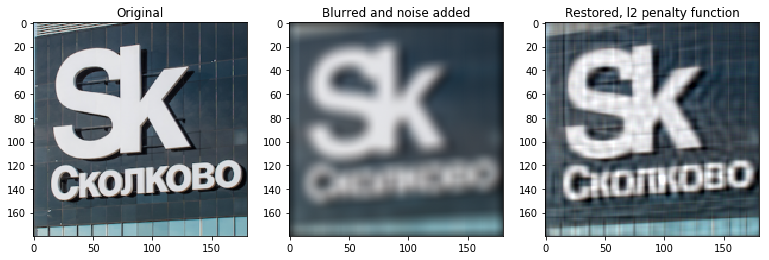

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(13, 13))

ax[0].imshow(img2, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(blurred_with_noise2, cmap='gray')
ax[1].set_title('Blurred and noise added')
ax[2].imshow(img2_final_l2, cmap='gray')
ax[2].set_title('Restored, l2 penalty function')

**The restoration worked not bad, the text on the image has become more visible**

**Now let's try to restore another strongly blurred image**

In [24]:
tau = 1e-3
tol = 100

In [49]:
img_new = plt.imread('kremlin.png')

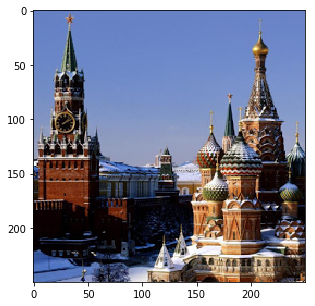

In [50]:
plt.figure(figsize=(5, 5))
plt.imshow(img_new)

In [52]:
ones = np.ones((img_new.shape[0], img_new.shape[0], 4))
ones[:, :, :3] = img_new
img_new = ones

In [53]:
pad2 = (k2//2, k2//2 + 1)

In [54]:
pad_img_new = resize_img(img_new, pad2)

In [55]:
A_new = create_matrix(kernel2, img_new.shape[0])

In [56]:
new_img_n = A_new @ pad_img_new
new_size_n = int(np.sqrt(new_img_n.shape[0]))
blurred_img_new = new_img_n.reshape((new_size_n, new_size_n, img_new.shape[2] - 1))

In [57]:
sigma= 1e-3
blurred_with_noise_new = blurred_img_new + sigma * np.random.randn(blurred_img_new.shape[0], blurred_img_new.shape[1], 3)

In [61]:
blurred_with_noise_new[blurred_with_noise_new > 1] = 1
blurred_with_noise_new[blurred_with_noise_new < 0] = 0

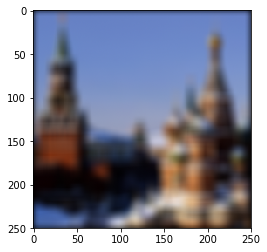

In [62]:
plt.imshow(blurred_with_noise_new)

In [63]:
H_new_l2 = hessian(A_new, tau, norm = 'l2')

In [67]:
y_new = resize_y(blurred_with_noise_new, pad2)
z_new = blurred_with_noise_new.reshape((blurred_with_noise_new.shape[0] ** 2, 3))

In [72]:
start = time()
y_new_final_l2_blur, loss_new_l2_blur, RMSE_new_l2_blur = newton(A_new, y_new, z_new, tau, tol, H_new_l2, pad_img_new, norm='l2')
finish = time()
print("Time: %.2f sec" % (finish - start))

Time: 2367.71 sec


In [73]:
size_new = int(np.sqrt(y_new_final_l2_blur.shape[0]))

In [76]:
img_new_final_l2 = y_new_final_l2_blur.reshape((size_new, size_new, 3))[pad2[0]:-pad2[1], pad2[0]:-pad2[1], :]

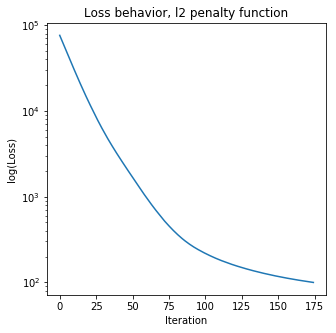

In [92]:
plt.figure(figsize=(5, 5))
plt.title('Loss behavior, l2 penalty function')
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.semilogy(loss2_l2_blur)

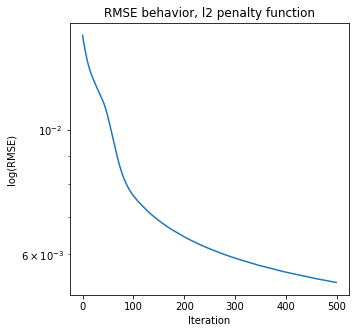

In [94]:
plt.figure(figsize=(5, 5))
plt.title('RMSE behavior, l2 penalty function')
plt.xlabel('Iteration')
plt.ylabel('log(RMSE)')
plt.semilogy(RMSE_new_l2_blur)

Text(0.5,1,'Restored, l2 penalty function')

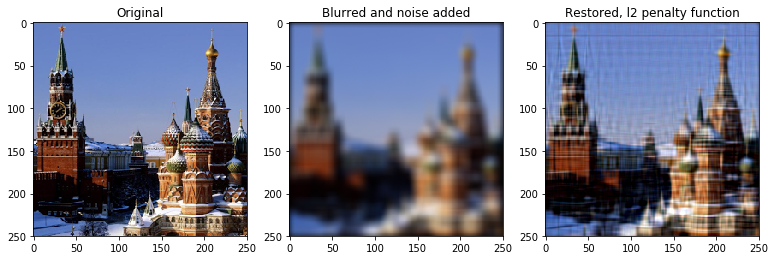

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(13, 13))

ax[0].imshow(img_new, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(blurred_with_noise_new, cmap='gray')
ax[1].set_title('Blurred and noise added')
ax[2].imshow(img_new_final_l2, cmap='gray')
ax[2].set_title('Restored, l2 penalty function')

**The restoration is not perfect, but the image has become more detailed, so the result is visible**